In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
# Load csv into df
df = pd.read_csv(data_interim_dir + 'merged_data.csv',parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Remove basin rig counts
df = df.iloc[:,5:]

# Filter values for only past months
df = df[df.index < this_month]
df = df.reset_index()
df.head()

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2020-08-28,180.0,33.096,39.220,42.932,45.258,2.63050,1.898,1146.566,10.050,...,28.811321,31.547123,7.593252,62.988280,39.220,43.811816,39.220,52.536276,39.220,96.348093
1,2020-08-21,183.0,26.398,38.350,42.726,44.792,2.95375,2.553,1157.228,10.400,...,28.813293,31.543548,7.582903,62.921314,38.350,43.572078,38.350,52.246733,38.350,95.818811
2,2020-08-14,172.0,23.464,37.872,42.076,44.538,2.79925,3.593,1163.680,10.475,...,28.815265,31.539973,7.572554,62.854347,37.872,43.332339,37.872,51.957190,37.872,95.289529
3,2020-08-07,176.0,15.712,37.322,41.568,44.356,2.63800,2.478,1167.983,10.550,...,28.817237,31.536398,7.562205,62.787381,37.322,43.092600,37.322,51.667647,37.322,94.760247
4,2020-07-31,180.0,3.324,34.185,40.686,43.224,2.77450,3.191,1174.737,10.600,...,28.786449,31.532662,7.583468,62.703200,34.185,42.866169,34.185,51.407257,34.185,94.273426


In [4]:
df.describe()

,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,930.600000,70.500197,70.037340,69.180553,76.755011,6.751362,6.731252,1093.498316,8.450045,8.464440,35.266772,32.298248,2.252154,60.369373,70.037340,46.353795,70.037340,48.878156,70.037340,95.231951
std,387.143193,23.644141,23.834185,23.993532,28.605105,1.748627,1.811515,59.280595,2.125931,2.121588,1.792355,0.787375,1.304765,3.720457,23.834185,1.848984,23.834185,3.373133,23.834185,4.368257
min,172.000000,3.324000,3.324000,3.324000,14.236000,1.997500,1.866000,997.074000,4.932750,4.506000,27.249729,29.738710,0.798167,54.123720,3.324000,35.169788,3.324000,41.998207,3.324000,81.081620
25%,670.000000,50.542000,50.227500,49.151500,52.686000,6.070375,6.079500,1044.902750,6.801187,6.828500,34.517828,31.738004,1.635733,57.362719,50.227500,45.885470,50.227500,46.118646,50.227500,91.876330
50%,843.500000,64.104000,62.987000,61.598000,67.870000,7.214875,7.162000,1079.884000,8.539875,8.546500,35.366460,32.314263,2.029850,60.858994,62.987000,46.578796,62.987000,49.194502,62.987000,95.204843
75%,1357.000000,93.973625,93.973625,93.973625,108.427500,7.797437,7.897750,1140.698750,9.954500,9.963250,36.517047,32.768237,2.467728,62.387381,93.973625,47.416907,93.973625,51.655833,93.973625,99.184324
max,1609.000000,112.296000,112.296000,112.296000,126.624000,9.474250,9.871000,1227.678000,12.550000,12.600000,37.737702,33.946000,9.080444,67.705728,112.296000,48.904341,112.296000,54.729117,112.296000,102.590146


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   500 non-null    datetime64[ns]
 1   Total US RigCount      500 non-null    float64       
 2   wti_spot_lag_14        500 non-null    float64       
 3   wti_spot_lag_9         500 non-null    float64       
 4   wti_spot               500 non-null    float64       
 5   brent_spot             500 non-null    float64       
 6   usa_net_import_smooth  500 non-null    float64       
 7   usa_net_import         500 non-null    float64       
 8   usa_stocks_all         500 non-null    float64       
 9   usa_l48_prod_smooth    500 non-null    float64       
 10  usa_l48_prod           500 non-null    float64       
 11  opec_tot_prod          500 non-null    float64       
 12  opec_crud_capac        500 non-null    float64       
 13  opec_

Looks good! Let's get started.

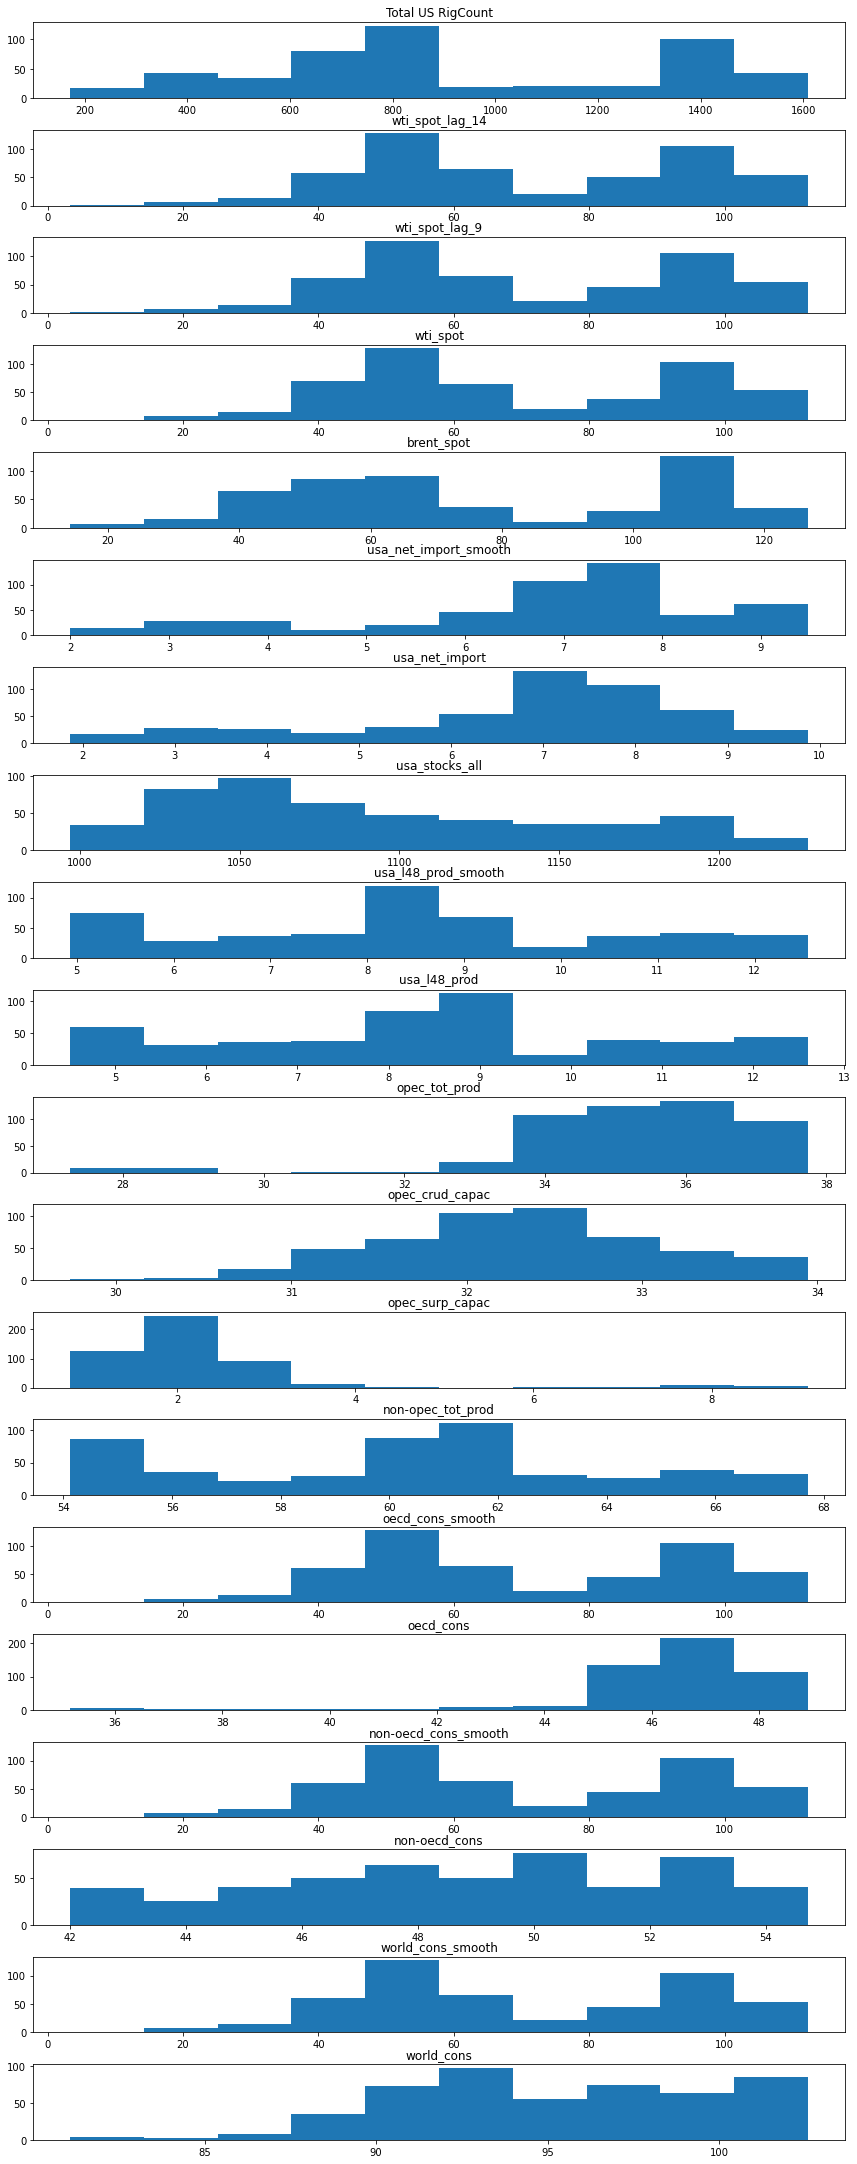

In [6]:
fig, ax = plt.subplots(len(df.columns)-1,figsize=(12,30))
fig.tight_layout()
for i in range(1,len(df.columns)):
    ax[i-1].hist(df.iloc[:,i])
    ax[i-1].set(title=df.columns[i])

Values between the features are very inconsistent and as such should be scaled to minimize any weighting issues with number sizes.

In [7]:
scaler = MinMaxScaler()

df_scaled = df.copy()

for col in df.columns[2:]:
    scaler.fit(df[[col]])
    df_scaled[col] = scaler.transform(df[[col]])
    
df_scaled.describe()

,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,930.600000,0.616454,0.612206,0.604344,0.556278,0.635819,0.607777,0.418138,0.461754,0.489059,0.764404,0.608358,0.175554,0.459848,0.612206,0.814297,0.612206,0.540413,0.612206,0.657894
std,387.143193,0.216974,0.218718,0.220181,0.254521,0.233875,0.226298,0.257067,0.279094,0.262119,0.170896,0.187145,0.157537,0.273925,0.218718,0.134623,0.218718,0.264956,0.218718,0.203094
min,172.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,670.000000,0.433304,0.430418,0.420544,0.342118,0.544739,0.526359,0.207406,0.245290,0.286941,0.692994,0.475198,0.101127,0.238477,0.430418,0.780199,0.430418,0.323656,0.430418,0.501881
50%,843.500000,0.557758,0.547508,0.534761,0.477222,0.697813,0.661587,0.359100,0.473547,0.499197,0.773909,0.612164,0.148713,0.495897,0.547508,0.830679,0.547508,0.565262,0.547508,0.656634
75%,1357.000000,0.831862,0.831862,0.831862,0.838092,0.775730,0.753498,0.622820,0.659260,0.674234,0.883614,0.720066,0.201582,0.608427,0.831862,0.891701,0.831862,0.758597,0.831862,0.841652
max,1609.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train / Test Split
Define features X, and target variable y

In [8]:
X = df_scaled.iloc[:,2:]
y = df_scaled.iloc[:,1]

Train / test split will be done using sklearn's TimeSeriesSplit. Will need to be redefined and used in a pipeline in the modelling phase.

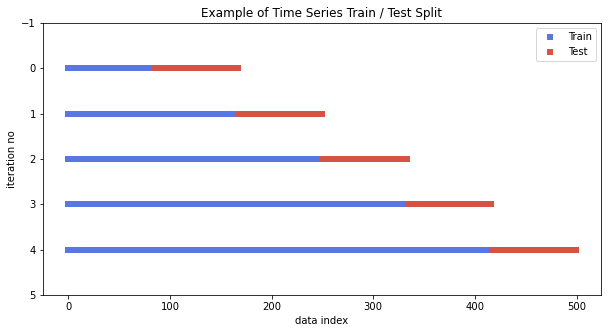

In [9]:
n_splits = 5

ts_cv = TimeSeriesSplit(n_splits = n_splits)

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

fig, ax = plt.subplots(figsize=(10,5))
for ii, (tr,tt) in enumerate(ts_cv.split(X,y)):
    train = ax.scatter(tr,[ii]*len(tr), c=[plt.cm.coolwarm(.1)],marker='_',lw=6,label='Train')
    test = ax.scatter(tt,[ii]*len(tt), c=[plt.cm.coolwarm(.9)],marker='_',lw=6,label='Test')
    
    ax.set(ylim=[5,-1], title='Example of Time Series Train / Test Split',xlabel='data index',ylabel='iteration no')
    ax.legend([train,test],['Train','Test'])

In [10]:
# Save preprocessed file as CSV
df.to_csv(data_processed_dir+'processed_data.csv',index=False)